In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BT_Plus/Chapter_2'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/BT_Plus/Chapter_2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('retail_transactions.csv')
df['Revenue'] = df['UnitPrice']*df['Quantity']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
operations = {
    'Revenue': 'sum',
    'Quantity': 'sum',
    'Country': 'first',
    'InvoiceDate': 'first',
    'CustomerID': 'first',
}
df = df.groupby('InvoiceNo').agg(operations).reset_index()
df['Year'] = df['InvoiceDate'].apply(lambda x: x.year)
df['Month'] = df['InvoiceDate'].apply(lambda x: x.month)
df.drop(columns=['Country'], inplace=True)
df.head()

,InvoiceNo,Revenue,Quantity,InvoiceDate,CustomerID,Year,Month
0,536365,139.12,40,2010-12-01 08:26:00,17850.0,2010,12
1,536366,22.20,12,2010-12-01 08:28:00,17850.0,2010,12
2,536367,278.73,83,2010-12-01 08:34:00,13047.0,2010,12
3,536368,70.05,15,2010-12-01 08:34:00,13047.0,2010,12
4,536369,17.85,3,2010-12-01 08:35:00,13047.0,2010,12


In [ ]:
print('Number of Transactions in 2010: ', df[df['Year'] == 2010].count()[0])
print('Number of Transactions in 2011: ', df[df['Year'] == 2011].count()[0])
print('\n')
print('Data collect from: ', df['InvoiceDate'].min())
print('Data collect from: ', df['InvoiceDate'].max())



Number of Transactions in 2010:  1400
Number of Transactions in 2011:  17132


Data collect from:  2010-12-01 08:26:00
Data collect from:  2011-12-09 12:50:00


### Planning for modeling:

- Because too little data in 2010 compare to data collect in 2011 (1,400 vs 17,132), we can not use data 2010 to predict data 2011

- Data actually collect from Dec-2010 to Early Dec-2011, and our data is time-series data, which mean Past use to predict Future

- Suggest change our probem to: Predict next 3 months revenue from customer purchase goods for last 6 months

- Because some Customers have revenue last 6 months but next 3 months dont have revenue.

- So Suggest use Linear Regression to Forecast next 3 months revenue from Customers who had record revenue last 6 month

In [ ]:
last_date_train = pd.datetime(year=2011, month=5, day=31)
last_date_test = pd.datetime(year=2011, month=8, day=31)

# Create data_train use 6 months 12/2010, 1-5/2011 for X_train, next 3 months 6-8/2011 for y_train
X_train = df[df['InvoiceDate'] <= last_date_train]
y_train = df[(df['InvoiceDate'] > last_date_train) & \
             (df['InvoiceDate'] <= last_date_test)][['CustomerID', 'Revenue']]

# Create data_train use 6 months 3-8/2011 for X_test, next 3 months 9-1/2011 for y_test
X_test = df[(df['InvoiceDate'] >= pd.datetime(year=2011, month=3, day=1)) & \
             (df['InvoiceDate'] <= last_date_test)]
y_test = df[(df['InvoiceDate'] > last_date_test) & \
             (df['InvoiceDate'] <= pd.datetime(year=2011, month=11, day=30))][['CustomerID', 'Revenue']]

# Feature extraction Days_since
X_train['Days_since'] = (last_date_train - X_train['InvoiceDate']).apply(lambda x: x.days + 1)
X_test['Days_since'] = (last_date_test - X_test['InvoiceDate']).apply(lambda x: x.days + 1)

X_train

,InvoiceNo,Revenue,Quantity,InvoiceDate,CustomerID,Year,Month,Days_since
0,536365,139.12,40,2010-12-01 08:26:00,17850.0,2010,12,181
1,536366,22.20,12,2010-12-01 08:28:00,17850.0,2010,12,181
2,536367,278.73,83,2010-12-01 08:34:00,13047.0,2010,12,181
3,536368,70.05,15,2010-12-01 08:34:00,13047.0,2010,12,181
4,536369,17.85,3,2010-12-01 08:35:00,13047.0,2010,12,181
...,...,...,...,...,...,...,...,...
7353,554995,161.71,82,2011-05-29 14:23:00,18109.0,2011,5,2
7354,554996,194.40,92,2011-05-29 14:28:00,16407.0,2011,5,2
7355,554997,321.96,226,2011-05-29 15:35:00,16746.0,2011,5,2
7356,554998,207.15,93,2011-05-29 15:35:00,15925.0,2011,5,2


In [ ]:
# Create a function to preprocess X, y
def preprocess_X_y(X, y):
    op_agg_x = {
        'Revenue': 'sum',
        'Quantity': 'sum',
        'InvoiceNo': 'count',
        'Days_since': ['min', 'max'],
    }
    X = X.groupby('CustomerID').agg(op_agg_x).reset_index()
    X.columns = ['CustomerID', 'Last_6_months_rev', 'Quantity', \
                    'Number_purchases', 'Days_since_last_purchase', 'Days_since_first_purchase']
    X['Avg_order_cost'] = X['Last_6_months_rev']/X['Number_purchases']
    y = y.groupby('CustomerID').sum().reset_index()
    
    # Merge data
    data = pd.merge(X, y, on='CustomerID', how='left')
    data = data.fillna(0)

    X = data.drop(columns=['Revenue', 'CustomerID'])
    y = data['Revenue']
    return X, y
X_train, y_train = preprocess_X_y(X_train, y_train)
X_test, y_test = preprocess_X_y(X_test, y_test)
X_train

,Last_6_months_rev,Quantity,Number_purchases,Days_since_last_purchase,Days_since_first_purchase,Avg_order_cost
0,77183.60,74215,1,133,133,77183.600000
1,1823.43,1117,3,54,175,607.810000
2,1487.24,2124,3,56,166,495.746667
3,334.40,197,1,118,118,334.400000
4,1561.81,254,5,70,104,312.362000
...,...,...,...,...,...,...
2703,980.54,788,2,33,54,490.270000
2704,51.00,20,1,65,65,51.000000
2705,180.60,45,1,85,85,180.600000
2706,535.05,336,5,8,145,107.010000


In [ ]:
# This seem pretty long in coding, but I code it for only once time and use for many times with many model can use
def print_regression_result(model, X_train, y_train, X_test, y_test, degree=1, ReLU_layer=True):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    ReLU = lambda x: x if x > 0 else 0
    if ReLU_layer:
        y_pred_train = pd.Series(y_pred_train).map(ReLU)
        y_pred_test = pd.Series(y_pred_test).map(ReLU)
    # print('Mean of target value: {:,.0f}'.format(np.mean(pd.concat([y_train, y_test]))))
    # print('Median of target value: {:,.0f} \n'.format(np.median(pd.concat([y_train, y_test]))))

    print('MSE_train : {:,.0f}'.format(mean_squared_error(y_train, y_pred_train)))
    print('RMSE_train: {:,.0f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    print('MAE_train : {:,.0f}'.format(mean_absolute_error(y_train, y_pred_train)))
    print('R2_train  : {:.4f} \n'.format(r2_score(y_train, y_pred_train)))

    print('MSE_test  : {:,.0f}'.format(mean_squared_error(y_test, y_pred_test)))
    print('RMSE_test : {:,.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('MAE_test  : {:,.0f}'.format(mean_absolute_error(y_test, y_pred_test)))
    print('R2_test   : {:.4f} \n'.format(r2_score(y_test, y_pred_test)))

def plot_resi_chart(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    min = np.min([y_test, y_pred_test])
    max = np.max([y_test, y_pred_test])

    plt.figure(figsize=(8,6))
    plt.scatter(y_pred_test, y_test)
    plt.plot([min, max], [min, max], 'k-', color='r')
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Residual Plot on Test set')
    plt.show()

def plot_dist_chart(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    sb.kdeplot(y_train, color='r', label='Actual Train Values')
    sb.kdeplot(y_pred_train, color='b', label='Predicted Train Values')
    plt.legend()
    plt.title('Distribution of Actual-Predicted Train Values')
    
    plt.subplot(1,2,2)
    sb.kdeplot(y_test, color='r', label='Actual Test Values')
    sb.kdeplot(y_pred_test, color='b', label='Predicted Test Values')
    plt.legend()
    plt.title('Distribution of Actual-Predicted Test Values')
    plt.show()

def select_k_best_features(X_train, y_train, X_test, y_test, k_best_features):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression

    best_k_features = SelectKBest(score_func=f_regression, k=k_best_features)
    best_k_features.fit(X_train, y_train)
    score = pd.Series(best_k_features.scores_)
    col = pd.Series(X_train.columns)
    result_best_features = pd.DataFrame({'Features': col, 'Score': score}).sort_values(by='Score', ascending=False)
    print('Table score of Features')
    display(result_best_features)
    print('\n')
    if k_best_features == 'all':
        print('All features will be selected for model.\n')
    else:
        print('Features selected: ')
        for features in result_best_features['Features'][:k_best_features]:
            print('\t', features)
        print('\n')
    X_train = best_k_features.transform(X_train)
    X_test = best_k_features.transform(X_test)
    return X_train, X_test

MSE_train : 1,858,220
RMSE_train: 1,363
MAE_train : 422
R2_train  : 0.7552 

MSE_test  : 5,447,828
RMSE_test : 2,334
MAE_test  : 596
R2_test   : 0.6988 



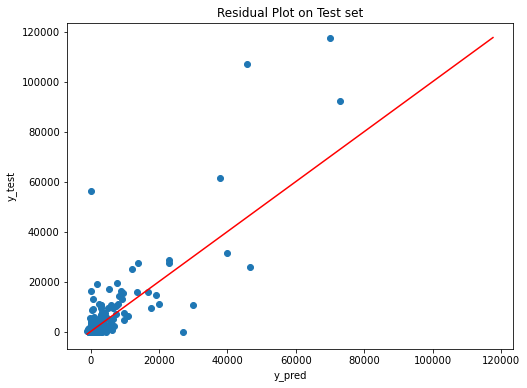

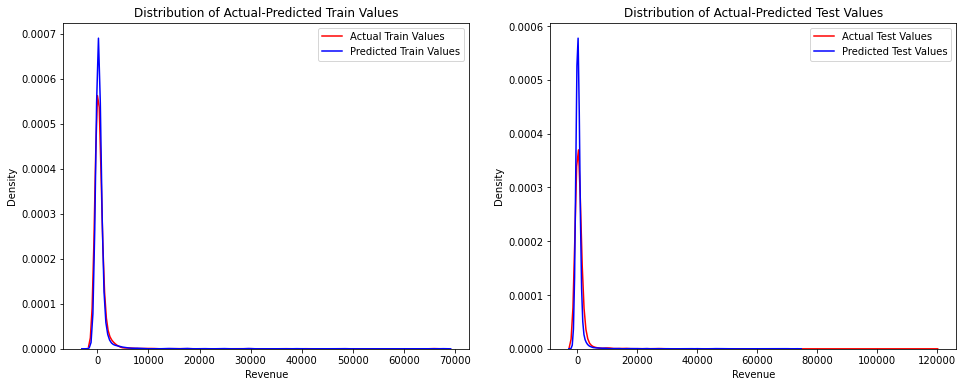

In [ ]:
model = LinearRegression()
print_regression_result(model, X_train, y_train, X_test, y_test, ReLU_layer=True)
plot_resi_chart(model, X_train, y_train, X_test, y_test)
plot_dist_chart(model, X_train, y_train, X_test, y_test)
# Result on test set 69.88% and train set 75.5% indicate not having problem of overfitting, but have problem about underfitting

Table score of Features


,Features,Score
0,Last_6_months_rev,4725.799597
1,Quantity,1946.868581
2,Number_purchases,607.921682
3,Days_since_last_purchase,47.996957
5,Avg_order_cost,45.650255
4,Days_since_first_purchase,41.117514




All features will be selected for model.

MSE_train : 8
RMSE_train: 3
MAE_train : 1
R2_train  : 0.7552 

MSE_test  : 24
RMSE_test : 5
MAE_test  : 1
R2_test   : 0.6988 



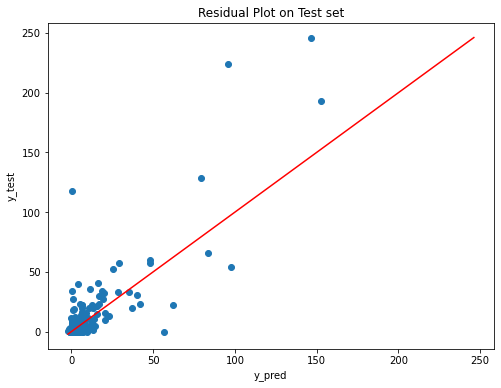

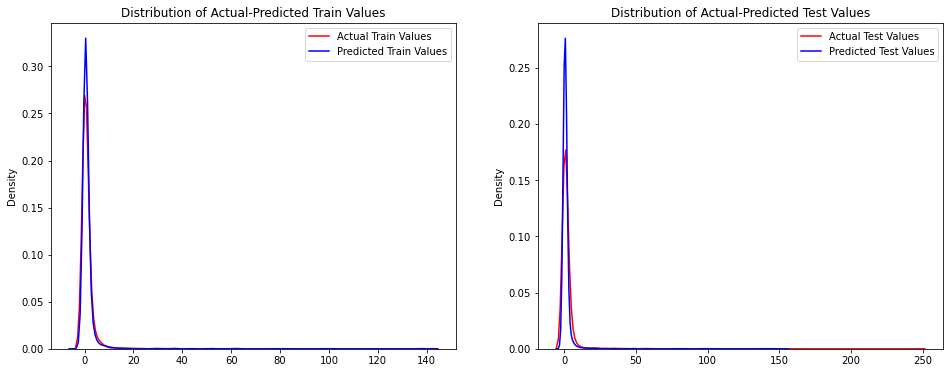

In [ ]:
# Because revenue range is very large (from 0 to 120.000), try to use Scaler to see can be improved or not
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
std_scaler = RobustScaler() # Can change scaler here
y_train_new = std_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_new = std_scaler.transform(np.array(y_test).reshape(-1,1))
y_train_new = pd.Series(y_train_new.flatten())
y_test_new = pd.Series(y_test_new.flatten())

# Run new result on new Scaled data
X_train_select, X_test_select = select_k_best_features(X_train, y_train_new, X_test, y_test_new, 'all')
print_regression_result(model, X_train_select, y_train_new, X_test_select, y_test_new)
plot_resi_chart(model, X_train_select, y_train_new, X_test_select, y_test_new)
plot_dist_chart(model, X_train_select, y_train_new, X_test_select, y_test_new)

# Result: Scaled value did not help in this problem

Table score of Features


,Features,Score
0,Last_6_months_rev,4725.799597
1,Quantity,1946.868581
2,Number_purchases,607.921682
3,Days_since_last_purchase,47.996957
5,Avg_order_cost,45.650255
4,Days_since_first_purchase,41.117514




Features selected: 
	 Last_6_months_rev
	 Quantity
	 Number_purchases


MSE_train : 8
RMSE_train: 3
MAE_train : 1
R2_train  : 0.7594 

MSE_test  : 19
RMSE_test : 4
MAE_test  : 1
R2_test   : 0.7659 



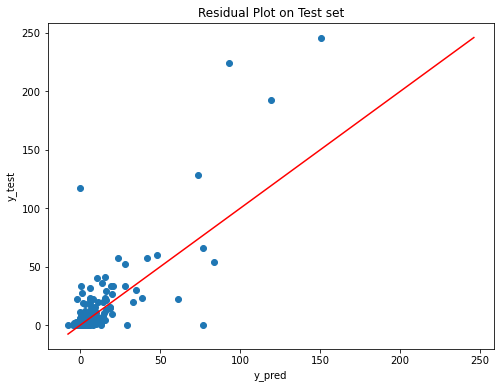

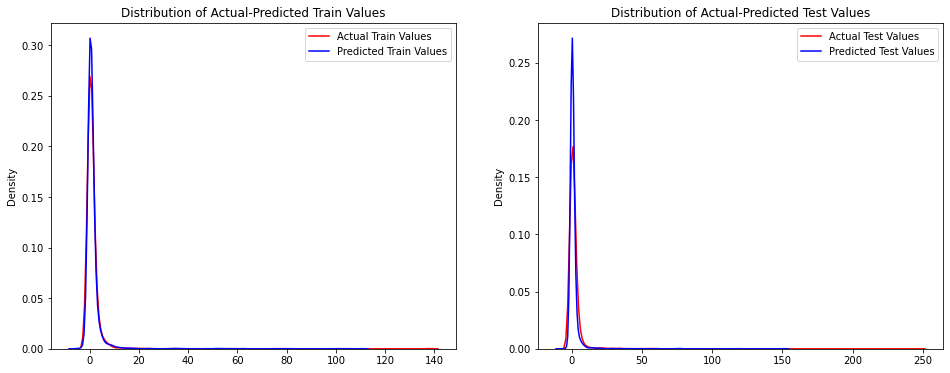

In [ ]:
# Try to run Polynorminal with Degree = 2
X_train_select, X_test_select = select_k_best_features(X_train, y_train_new, X_test, y_test_new, 3)
print_regression_result(model, X_train_select, y_train_new, X_test_select, y_test_new, degree=2)
plot_resi_chart(model, X_train_select, y_train_new, X_test_select, y_test_new)
plot_dist_chart(model, X_train_select, y_train_new, X_test_select, y_test_new)

# Result: R2 on test set improved, not overfitting, but still underfitting

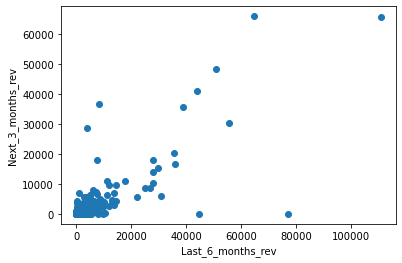

In [ ]:
plt.scatter(X_train['Last_6_months_rev'], y_train)
plt.xlabel('Last_6_months_rev')
plt.ylabel('Next_3_months_rev')
plt.show()
# Try to break train, test data to 2 parts base on Last_6_months_rev
#   1st: lower than 20.000 revenue 
#   2nd: higher than 20.000 revenue
# Then make 2 model for regression and concat the result of 2 parts

In [ ]:
def model_predict(model, X_train, y_train, X_test, y_test, degree=1, ReLU_layer=True):
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    ReLU = lambda x: x if x > 0 else 0
    if ReLU_layer:
        y_pred_train = pd.Series(y_pred_train).map(ReLU)
        y_pred_test = pd.Series(y_pred_test).map(ReLU)
    return y_pred_train, y_pred_test

def print_regression_result_2_models(model_1, model_2, X_train, y_train, X_test, y_test, degree_m1=1, degree_m2=1, ReLU_layer=True, threshold=20000):
    threshold = threshold
    part_1_train = np.array([True if x < threshold else False for x in X_train['Last_6_months_rev']])
    part_1_test = np.array([True if x < threshold else False for x in X_test['Last_6_months_rev']])

    X_train_p1 = X_train[part_1_train]
    y_train_p1 = y_train[part_1_train]
    X_test_p1 = X_test[part_1_test]
    y_test_p1 = y_test[part_1_test]
    y_pred_train_p1, y_pred_test_p1 = model_predict(model_1, X_train_p1, y_train_p1, X_test_p1, y_test_p1, degree=degree_m1, ReLU_layer=ReLU_layer)

    X_train_p2 = X_train[~part_1_train]
    y_train_p2 = y_train[~part_1_train]
    X_test_p2 = X_test[~part_1_test]
    y_test_p2 = y_test[~part_1_test]
    y_pred_train_p2, y_pred_test_p2 = model_predict(model_2, X_train_p2, y_train_p2, X_test_p2, y_test_p2, degree=degree_m2, ReLU_layer=ReLU_layer)
    y_train = pd.concat([y_train_p1, y_train_p2])
    y_test = pd.concat([y_test_p1, y_test_p2])

    y_pred_train = pd.concat([y_pred_train_p1, y_pred_train_p2])
    y_pred_test = pd.concat([y_pred_test_p1, y_pred_test_p2])

    # print('Mean of target value: {:,.0f}'.format(np.mean(pd.concat([y_train, y_test]))))
    # print('Median of target value: {:,.0f} \n'.format(np.median(pd.concat([y_train, y_test]))))

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    print('MSE_train : {:,.0f}'.format(mean_squared_error(y_train, y_pred_train)))
    print('RMSE_train: {:,.0f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    print('MAE_train : {:,.0f}'.format(mean_absolute_error(y_train, y_pred_train)))
    print('R2_train  : {:.4f} \n'.format(r2_score(y_train, y_pred_train)))

    print('MSE_test  : {:,.0f}'.format(mean_squared_error(y_test, y_pred_test)))
    print('RMSE_test : {:,.0f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('MAE_test  : {:,.0f}'.format(mean_absolute_error(y_test, y_pred_test)))
    print('R2_test   : {:.4f} \n'.format(r2_score(y_test, y_pred_test)))

In [ ]:
model_1 = LinearRegression()
model_2 = LinearRegression()
print_regression_result_2_models(model_1, model_2, X_train, y_train, X_test, y_test, threshold=20000, degree_m1=1, degree_m2=1)
# Result: improved underfit a little on train set (75-77%), but not improved on test data

MSE_train : 1,712,980
RMSE_train: 1,309
MAE_train : 410
R2_train  : 0.7743 

MSE_test  : 5,286,563
RMSE_test : 2,299
MAE_test  : 580
R2_test   : 0.7077 



In [ ]:
# Try to poly d-2
model_1 = LinearRegression()
model_2 = LinearRegression()
print_regression_result_2_models(model_1, model_2, X_train, y_train, X_test, y_test, threshold=20000, degree_m1=2, degree_m2=1)
# Result: improved underfit a little on train set (75-77%), but still not improved on test data

MSE_train : 1,600,945
RMSE_train: 1,265
MAE_train : 406
R2_train  : 0.7891 

MSE_test  : 5,342,707
RMSE_test : 2,311
MAE_test  : 593
R2_test   : 0.7046 



In [ ]:
# Result is not better than not devide dataset

In [ ]:
# Try Support Vector Machine
from sklearn.svm import SVR

# After try many hyper parameter, I choose poly-d2 with C=100.000, it seem the best result SVM can have
model_svm = SVR(kernel='poly', degree=2, C=100000)
print_regression_result(model_svm, X_train, y_train, X_test, y_test)

MSE_train : 1,758,538
RMSE_train: 1,326
MAE_train : 365
R2_train  : 0.7683 

MSE_test  : 4,262,973
RMSE_test : 2,065
MAE_test  : 584
R2_test   : 0.7643 



### Conclusion: 

- Because too little data in 2010 compare to data collect in 2011 (1,400 vs 17,132), we can not use data 2010 to predict data 2011

- Our data is time-series data, which mean Past use to predict Future

- Change our probem to: Predict next 3 months revenue from customer purchase goods for last 6 months

- Best result I have try is by Polynominal with degree 2: train_R2 = 76%, test_R2 = 76%

- Result indicate: Not Overfitting, but still under fitting.

- I have try to use more power model like SVM but it not improve the underfit, still train-test R2 around 76%

- Maybe problem that 6 months data is not sufficient to make predictions for next 3 months, but result still at accepted level

- Maybe we can try another specialized method for time-series data